Instalando as bibliotecas

In [1]:
!pip install pandas selenium webdriver-manager seaborn matplotlib;


[notice] A new release of pip is available: 23.1.2 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


O código abaixo apresenta a extração de dados de uma página web e criação de insights através dos dados obtidos. Eu optei pela biblioteca selenium para extratir os dados da web, tratei com pandas e plotei os gráficos com seaborn e matplotlib.

      Ano                                           Empresa Emissão     Série  \
0    2024                                           Be8 S.A    295ª       1-2   
1    2024             Alcoeste Bioenergia Fernandópolis S.A    337ª         1   
2    2024                          Agropecuária Maggi LTDA.    349ª         1   
3    2024                           Sorocaba Refrescos S.A.    342ª       1-2   
4    2024                         Marfrig Global Foods S.A.    343ª         1   
..    ...                                               ...     ...       ...   
340  2010                                Produtores de Soja      1ª        36   
341  2010                        ETH Bio Participações S.A.      1ª        35   
342  2010  Agro industrial Espírito Santo do Turvo - Agrest      1ª        34   
343  2010                                Produtores de Soja      1ª  31-32-33   
344  2009  Agro industrial Espírito Santo do Turvo - Agrest      1ª     21-30   

                           

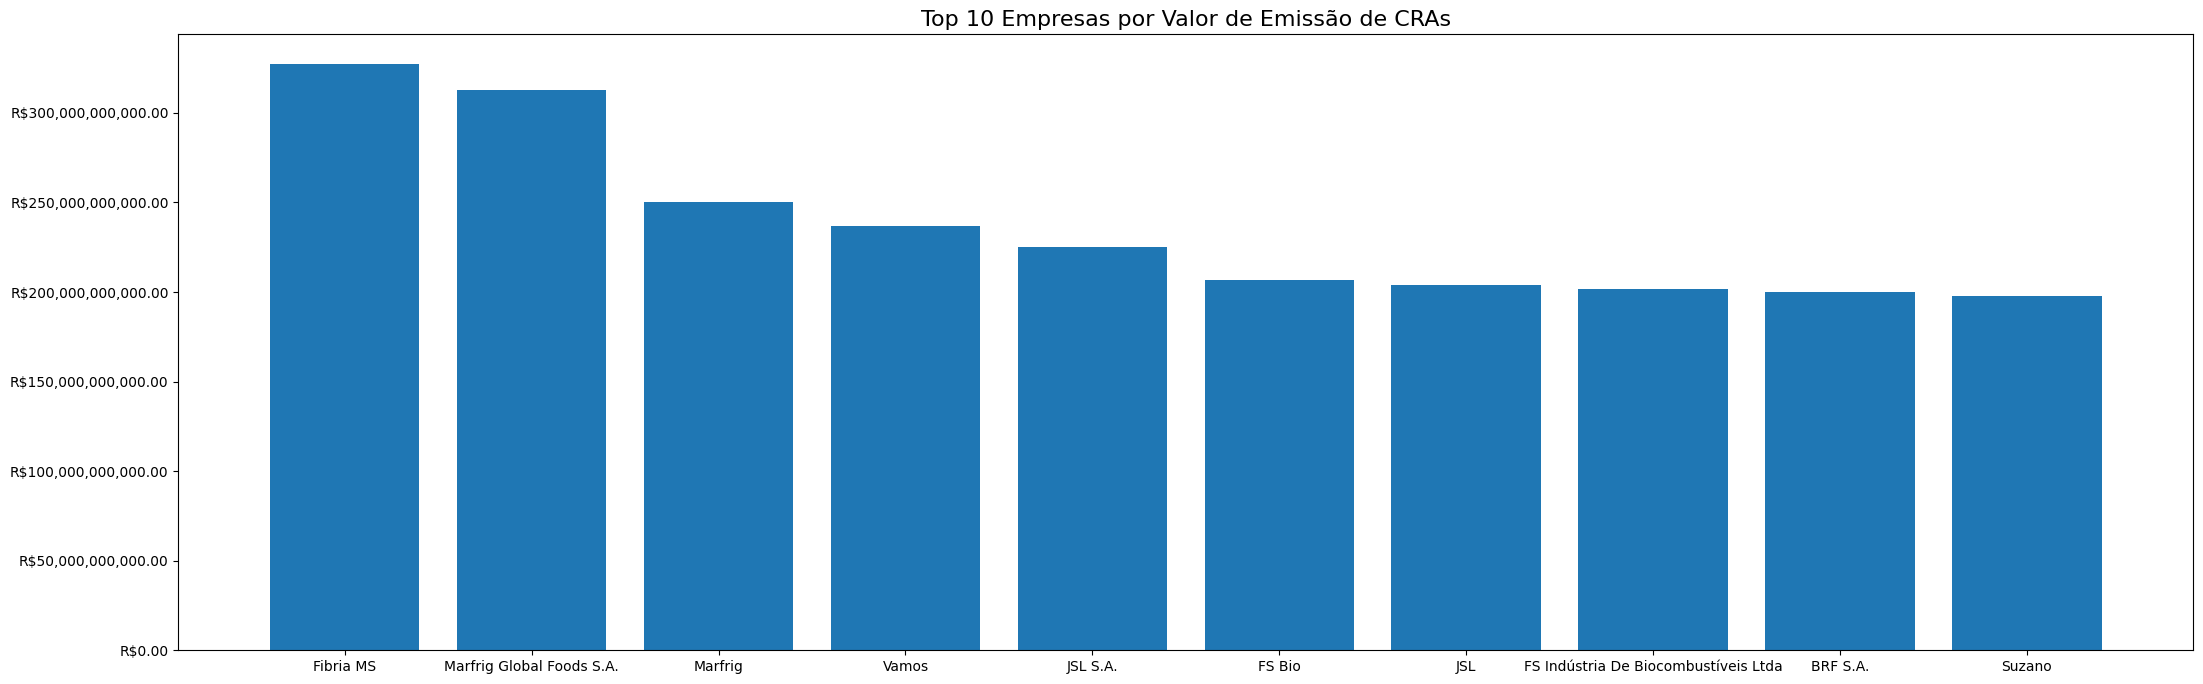

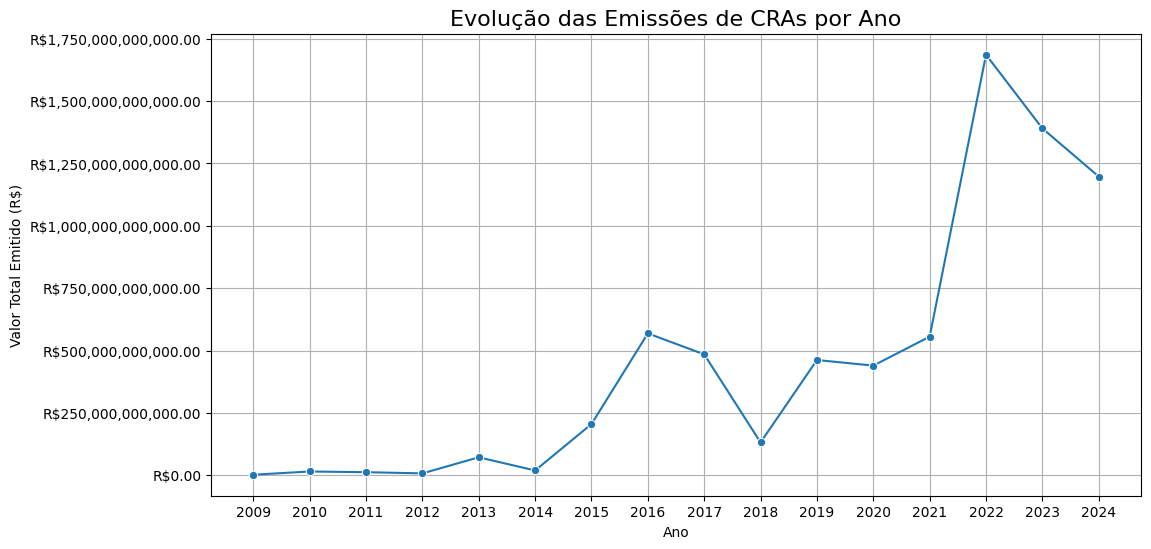

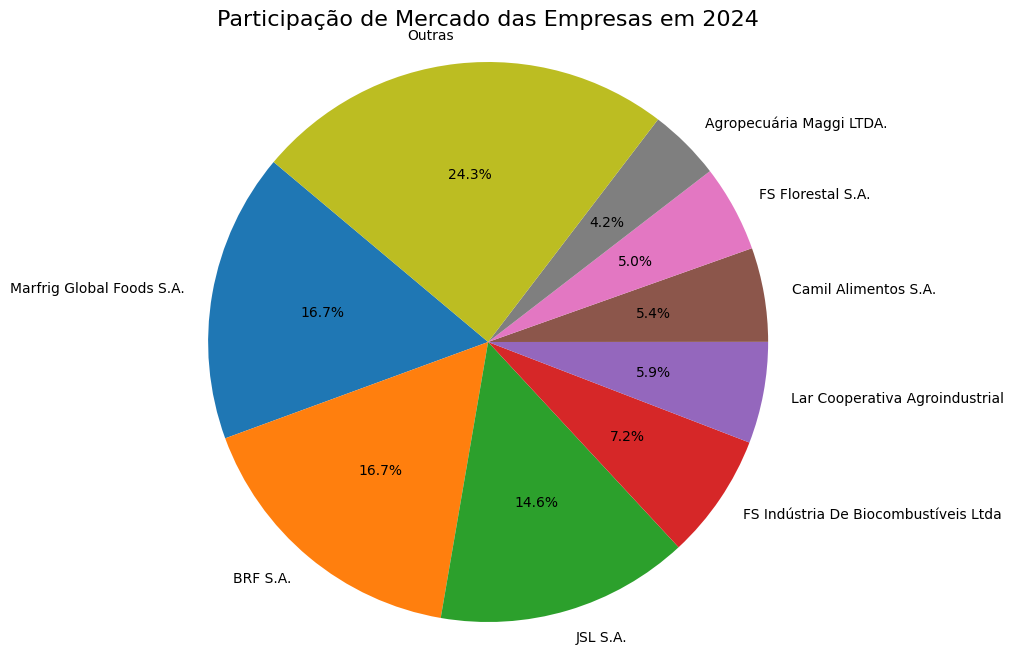

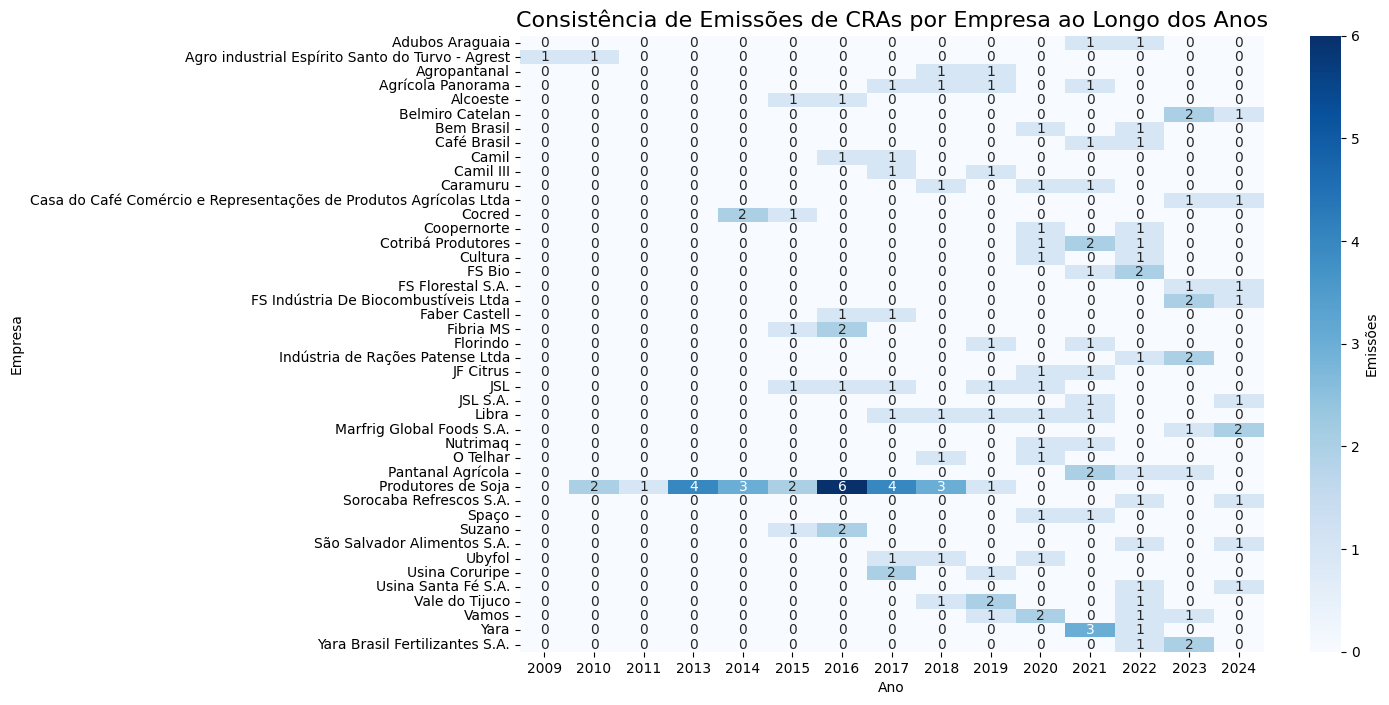

In [41]:
from selenium import webdriver
from time import sleep
import pandas as pd
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver import ChromeOptions
from webdriver_manager.chrome import ChromeDriverManager
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

#Função para processar os valores da coluna Valor
def processar_valor(valor):
    if valor[0:3] == 'USD':
        v = valor.replace('USD', '').replace(',', '').replace('.', '').strip()
        v = float(v) * taxa_cambio  
        return int(v)
    else:
        v = valor.replace('R$', '').replace('.', '').replace(',', '.').replace('.', '').strip()
        return int(float(v))  


def formato_moeda(x, pos):
    return f'R${x:,.2f}'
    

#Habilitando o chrome driver
opts = ChromeOptions()
#esta opcao serve para nao fechar o navegador apos a execucao do script
opts.add_experimental_option("detach", True)
servico=Service(ChromeDriverManager().install())
driver=webdriver.Chrome(service=servico, options=opts)

url_base = 'https://ecoagro.agr.br/emissoes?page='

# Lista para armazenar os dados de todas as páginas
dados_completos = []

# Cabeçalhos fixos da tabela
cabecalhos = ['Ano', 'Empresa', 'Emissão', 'Série', 'Cód. CETIP', 'Valor']

# Loop para navegar por todas as páginas (23 páginas no total)
for i in range(1, 24):
    # Abrir a URL da página correspondente
    driver.get(url_base + str(i))

    # Esperar até que a tabela esteja presente
    tabela = WebDriverWait(driver, 10).until(
        EC.presence_of_element_located((By.TAG_NAME, 'table'))
    )

    # Extrair as linhas da tabela
    linhas = tabela.find_elements(By.TAG_NAME, 'tr')

    # Extrair os dados das linhas, ignorando o cabeçalho
    for linha in linhas[1:]:
        colunas = linha.find_elements(By.TAG_NAME, 'td')
        linha_dados = [coluna.text for coluna in colunas]
        # Ignorar a última coluna "Acompanhar"
        dados_completos.append(linha_dados[:-1])  # Exclui a última coluna

    sleep(2)

# Converter a lista de dados em um DataFrame
df = pd.DataFrame(dados_completos, columns=cabecalhos)

driver.quit()

df.to_csv('emissoes.csv', index=False)

#Tratamento de dados da tabela
taxa_cambio = 5.00 #estimei a taxa como 5 

df['Valor'] = df['Valor'].apply(processar_valor) #verificar o def no topo do código

#printando o df para mostrar que agora ele ta limpinho e pronto pra ser manipulado
print(df)

#Insights e gráficos
maiores_emissoes_cra = df.groupby('Empresa')['Valor'].sum().sort_values(ascending=False).head(10)

df2 = maiores_emissoes_cra.reset_index()

#Primeiro insight -> Top 10 Empresas que mais emitiram CRAs
fig, ax = plt.subplots(figsize=(26, 8))
ax.bar(df2['Empresa'], df2['Valor'])
ax.set_title('Top 10 Empresas por Valor de Emissão de CRAs', fontsize=16)

# Aplicar a formatação ao eixo y
ax.yaxis.set_major_formatter(FuncFormatter(formato_moeda))

plt.show()

#Verificar como o valor total das emissões de CRAs mudou ao longo dos anos.
evolucao_ano = pd.DataFrame(df.groupby('Ano')['Valor'].sum()).reset_index()

#Segundo gráfico/insight -> Evolução das emissões durante os anos
plt.figure(figsize=(12, 6))
sns.lineplot(x='Ano', y='Valor', data=evolucao_ano, marker='o')
plt.title('Evolução das Emissões de CRAs por Ano', fontsize=16)
plt.xlabel('Ano')
plt.ylabel('Valor Total Emitido (R$)')

# Aplicar a formatação ao eixo y
ax = plt.gca()  # Obter o eixo atual
ax.yaxis.set_major_formatter(FuncFormatter(formato_moeda))

plt.grid(True)
plt.show()

#Terceiro insight -> Participação de mercado das empresas em 2024
ano_especifico = '2024' #Pode alterar o ano se quiser


# Filtrar dados do ano específico e calcular a participação de mercado
participacao_mercado = df[df['Ano'] == ano_especifico].groupby('Empresa')['Valor'].sum().reset_index()

# Ordenar por valor de participação
participacao_mercado = participacao_mercado.sort_values(by='Valor', ascending=False)

# Limitar o número de empresas a serem exibidas
top_n = 8  # Mostrar as 8 maiores empresas
outras = pd.DataFrame({'Empresa': ['Outras'], 'Valor': [participacao_mercado.iloc[top_n:]['Valor'].sum()]})
participacao_mercado = pd.concat([participacao_mercado.iloc[:top_n], outras], ignore_index=True)

plt.figure(figsize=(10, 8))
plt.pie(participacao_mercado['Valor'], labels=participacao_mercado['Empresa'], autopct='%1.1f%%', startangle=140)
plt.title(f'Participação de Mercado das Empresas em {ano_especifico}', fontsize=16)
plt.axis('equal') 
plt.show()

#Quarto insight -> Consistencia das emissoes de CRA ao longo dos anos
anos_minimos = 2  #incluir empresas que emitiram em pelo menos 2 anos

# Contar o número de anos em que cada empresa emitiu CRAs
empresa_anos = df.groupby('Empresa')['Ano'].nunique()

# Filtrar empresas que emitiram em pelo menos 'anos_minimos' anos
empresas_consistentes = empresa_anos[empresa_anos >= anos_minimos].index

# Filtrar o DataFrame original para incluir apenas as empresas consistentes
df_filtrado = df[df['Empresa'].isin(empresas_consistentes)]

# Criar uma tabela de consistência para o heatmap
consistencia_empresas = df_filtrado.groupby(['Empresa', 'Ano']).size().unstack(fill_value=0)

plt.figure(figsize=(12, 8))
sns.heatmap(consistencia_empresas, cmap='Blues', annot=True, fmt="d", cbar_kws={'label': 'Emissões'})
plt.title('Consistência de Emissões de CRAs por Empresa ao Longo dos Anos', fontsize=16)
plt.xlabel('Ano')
plt.ylabel('Empresa')
plt.show()

In [2]:
!pip freeze > requirements.txt